# 2. Predicting Loan Status and Analyzing Prediction Results Based on XAI.

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Splitting, Preprocessing, and Cross-validating data into training and testing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# XGBoost for machine learning
from xgboost import XGBClassifier

# For Explainable AI
import shap

# Other: Deep Learning
import torch 
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [2]:
# Read in credit into a dataframe 
credit = pd.read_csv('data/credit_data.csv')
credit.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0


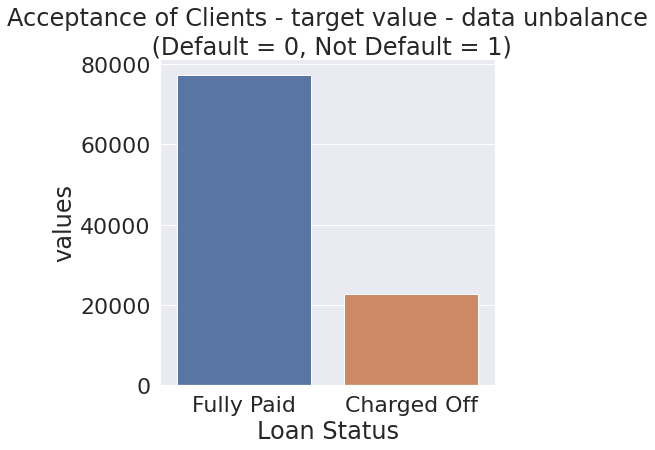

In [3]:
temp = credit["Loan Status"].value_counts()
df = pd.DataFrame({'Loan Status': temp.index,'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Acceptance of Clients - target value - data unbalance\n (Default = 0, Not Default = 1)')
sns.set_color_codes("pastel")
sns.barplot(x = 'Loan Status', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

In [4]:
# Verify the column data types and non-missing values
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100514 entries, 0 to 100513
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       100000 non-null  object 
 1   Customer ID                   100000 non-null  object 
 2   Loan Status                   100000 non-null  object 
 3   Current Loan Amount           100000 non-null  float64
 4   Term                          100000 non-null  object 
 5   Credit Score                  80846 non-null   float64
 6   Annual Income                 80846 non-null   float64
 7   Years in current job          95778 non-null   object 
 8   Home Ownership                100000 non-null  object 
 9   Purpose                       100000 non-null  object 
 10  Monthly Debt                  100000 non-null  float64
 11  Years of Credit History       100000 non-null  float64
 12  Months since last delinquent  46859 non-null

In [5]:
# Delete useless features
credit.drop(labels=['Loan ID', 'Customer ID'], axis=1, inplace=True)

In [6]:
# Preprocessing for Missing Values
# Function to calculate missing values by column for verifying data preprocessing results

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Your selected dataframe has 16 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


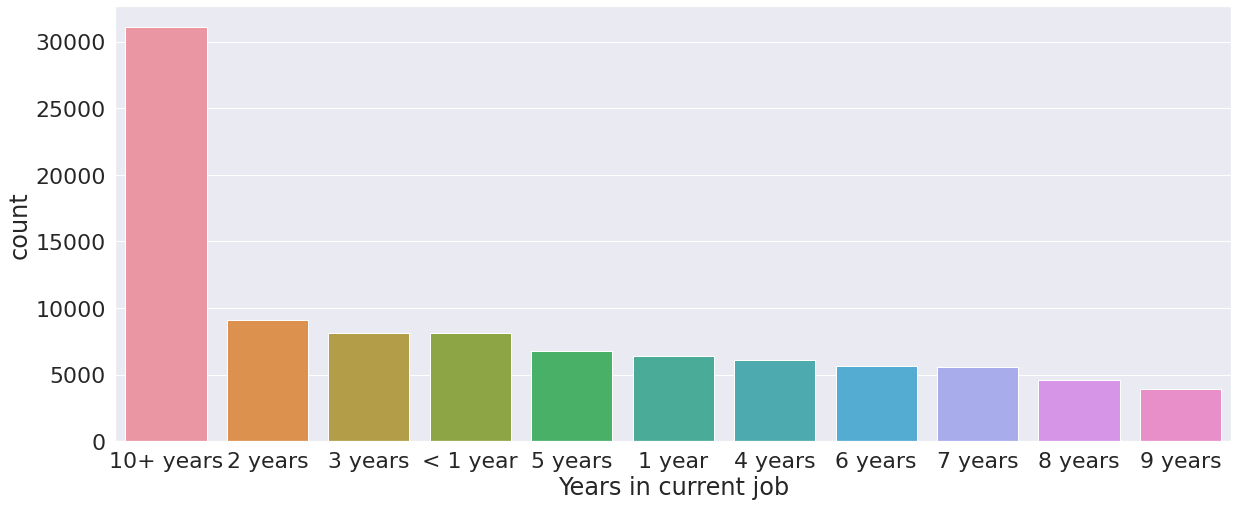

In [7]:
# Drop the columns with > 50% missing

credit.drop(columns = 'Months since last delinquent', axis=1, inplace=True)
credit[credit['Years of Credit History'].isnull() == True]

# Here I can see that the last 514 observations are NaN values.

credit.drop(credit.tail(514).index, inplace=True) # drop last 514 rows

# As the number of missing values is so low in the 'Maximum Open Credit' I will drop them.

for i in credit['Maximum Open Credit'][credit['Maximum Open Credit'].isnull() == True].index:
    credit.drop(labels=i, inplace=True)

# As the number of missing values is so low in the 'Tax Liens' I will drop them.

for i in credit['Tax Liens'][credit['Tax Liens'].isnull() == True].index:
    credit.drop(labels=i, inplace=True)

for i in credit['Bankruptcies'][credit['Bankruptcies'].isnull() == True].index:
    credit.drop(labels=i, inplace=True)

credit.fillna(credit.mean(), inplace=True)

plt.figure(figsize=(20,8))
sns.countplot(credit['Years in current job'], order = credit['Years in current job'].value_counts().index)
plt.savefig('images/countplot.pdf', bbox_inches='tight')

credit.fillna('10+ years', inplace=True) # fill with '10+ years'.
missing_values_table(credit)


In [8]:
# # # Feature Engineering and Selection

credit.columns

Index(['Loan Status', 'Current Loan Amount', 'Term', 'Credit Score',
       'Annual Income', 'Years in current job', 'Home Ownership', 'Purpose',
       'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens'],
      dtype='object')

In [9]:
# # Encoding categorical data & Feature Scaling

# Select the categorical columns
categorical_subset = credit[['Term', 'Years in current job', 'Home Ownership', 'Purpose']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the dataframe in credit_train
# Make sure to use axis = 1 to perform a column bind
# First I will drop the 'old' categorical datas and after I will join the 'new' one.

credit.drop(labels=['Term', 'Years in current job', 'Home Ownership', 'Purpose'], axis=1, inplace=True)
credit = pd.concat([credit, categorical_subset], axis = 1)

In [10]:
# #  Remove Collinear Features

def remove_collinear_features(x, threshold):
    
    # Dont want to remove correlations between Energy Star Score
    y = x['Loan Status']
    x = x.drop(columns = ['Loan Status'])
    
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    
    # Add the score back in to the data
    x['Loan Status'] = y
               
    return x

In [11]:
# Remove the collinear features above a specified correlation coefficient
credit = remove_collinear_features(credit, 0.6);

In [12]:
credit.shape

(99794, 42)

In [13]:
credit.head()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Tax Liens,Term_Long Term,Term_Short Term,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Home Ownership_HaveMortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Purpose_Business Loan,Purpose_Buy House,Purpose_Buy a Car,Purpose_Debt Consolidation,Purpose_Educational Expenses,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Other,Purpose_major_purchase,Purpose_moving,Purpose_other,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding,Loan Status
0,445412.0,709.000000,1.167493e+06,5214.74,17.2,6.0,1.0,228190.0,416746.0,0.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Fully Paid
1,262328.0,1076.275101,1.378339e+06,33295.98,21.1,35.0,0.0,229976.0,850784.0,0.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Fully Paid
2,99999999.0,741.000000,2.231892e+06,29200.53,14.9,18.0,1.0,297996.0,750090.0,0.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Fully Paid
3,347666.0,721.000000,8.069490e+05,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Fully Paid
4,176220.0,1076.275101,1.378339e+06,20639.70,6.1,15.0,0.0,253460.0,427174.0,0.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Fully Paid


In [14]:
# # # Split Into Training and Testing Sets

# Separate out the features and targets
features = credit.drop(columns='Loan Status')
targets = pd.DataFrame(credit['Loan Status'])

# Split into 80% training and 20% testing set
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(79835, 41)
(19959, 41)
(79835, 1)
(19959, 1)


In [15]:
# # Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Encoding the Dependent Variable
labelencoder_y_train = LabelEncoder()
y_train = labelencoder_y_train.fit_transform(y_train)
labelencoder_y_test = LabelEncoder()
y_test = labelencoder_y_test.fit_transform(y_test)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [16]:
def cross_val(X_train, y_train, model):
    # Applying k-Fold Cross Validation
    accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
    return accuracies.mean()

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_cross = cross_val(X_train, y_train, model)
    
    # Return the performance metric
    return model_cross

In [17]:
# # XGBoost Classification
gb = XGBClassifier()
gb_cross = fit_and_evaluate(gb)

print('XGBoost Classification Performance on the test set: Cross Validation Score = %0.4f' % gb_cross)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:45:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:45:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:45:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:46:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:46:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:46:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Classification Performance on the test set: Cross Validation Score = 0.8184


In [18]:
model = XGBClassifier(loss = 'ls', max_depth = 5,
                                  min_samples_leaf = 6,
                                  min_samples_split = 2,
                                  max_features = 'auto',
                                  n_estimators = 500,
                                  random_state = 42)


In [19]:
model.fit(X_train, y_train)

[15:46:14] WARNING: ../src/learner.cc:573: 
Parameters: { "loss", "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:46:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, loss='ls', max_delta_step=0,
              max_depth=5, max_features='auto', min_child_weight=1,
              min_samples_leaf=6, min_samples_split=2, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=12,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

### Confusion matrix plotting and precision - recall analysis

Model performance on the test set:   MSE = 0.1862.
(array([0.76106195, 0.81830549]), array([0.26502311, 0.97548002]), array([0.39314286, 0.89000681]), array([ 4543, 15416]))


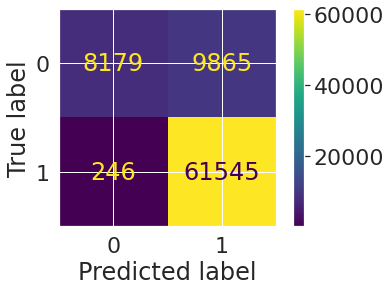

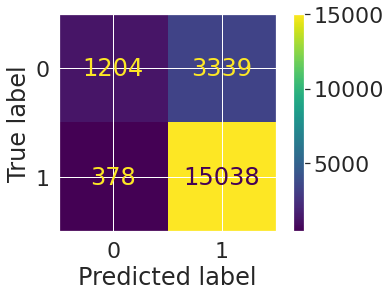

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support

final_pred = model.predict(X_test)
# Function to calculate mean absolute error
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)*(y_true - y_pred))

print('Model performance on the test set:   MSE = %0.4f.' % mse(y_test, final_pred))

# The final model does out-perform the baseline model by about less than 1% and at the cost of significantly increased running time (it's about 7 times slower on my machine). 
plot_confusion_matrix(model, X_train, y_train)
plt.savefig('images/xboost_confusion_matrix_train.pdf', bbox_inches='tight')
plot_confusion_matrix(model, X_test, y_test)
plt.savefig('images/xboost_confusion_matrix_test.pdf' , bbox_inches='tight')
print(precision_recall_fscore_support(y_test, final_pred))

## CatBoost

In [21]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(silent = True)

cat.fit(X_train, y_train)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Model performance on the test set:   MSE = 0.1809.
(array([0.89159664, 0.81448133]), array([0.23354611, 0.99163207]), array([0.3701378 , 0.89436888]), array([ 4543, 15416]))


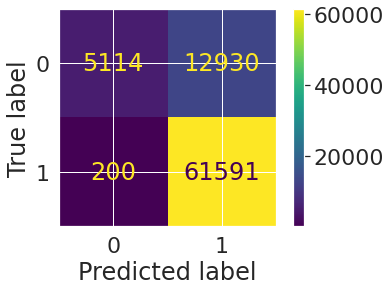

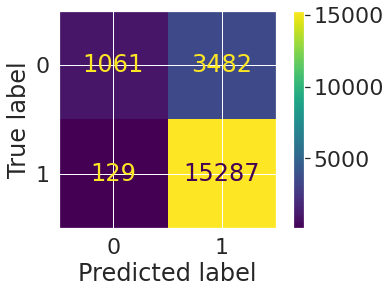

In [22]:
final_pred = cat.predict(X_test)
print(final_pred[100:120])
# Function to calculate mean absolute error
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)*(y_true - y_pred))

print('Model performance on the test set:   MSE = %0.4f.' % mse(y_test, final_pred))

# The final model does out-perform the baseline model by about less than 1% and at the cost of significantly increased running time (it's about 7 times slower on my machine). 
plot_confusion_matrix(cat, X_train, y_train)
plt.savefig('images/catboost_confusion_matrix_train.pdf', bbox_inches='tight')
plot_confusion_matrix(cat, X_test, y_test)
plt.savefig('images/catboost_confusion_matrix_test.pdf', bbox_inches='tight')
print(precision_recall_fscore_support(y_test, final_pred))

## LightGBM

In [23]:
import lightgbm

train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

lgbm = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100,
                       verbose_eval=False)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary


Model performance on the test set:   MSE = 0.1797.


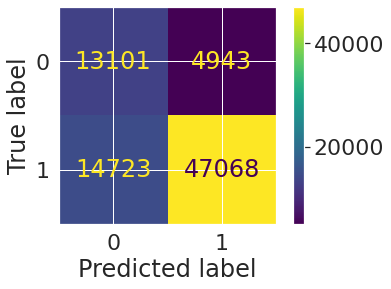

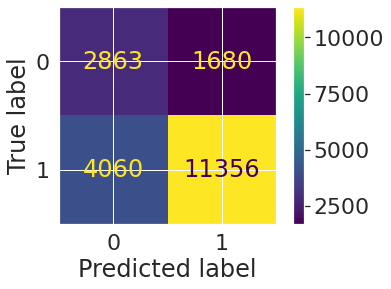

(array([0.41354904, 0.87112611]), array([0.63020031, 0.73663726]), array([0.4993895 , 0.79825671]), array([ 4543, 15416]))


In [24]:
final_pred = lgbm.predict(X_test)

# Function to calculate mean absolute error
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)*(y_true - y_pred))

print('Model performance on the test set:   MSE = %0.4f.' % mse(y_test, final_pred))

# The final model does out-perform the baseline model by about less than 1% and at the cost of significantly increased running time (it's about 7 times slower on my machine). 
cm = confusion_matrix(y_train, np.round(lgbm.predict(X_train)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()
plt.savefig('images/lightgbm_confusion_matrix_train.pdf', bbox_inches='tight')
plt.show()

# The final model does out-perform the baseline model by about less than 1% and at the cost of significantly increased running time (it's about 7 times slower on my machine).
cm = confusion_matrix(y_test, np.round(lgbm.predict(X_test)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()
plt.savefig('images/lightgbm_confusion_matrix_test.pdf', bbox_inches='tight')
plt.show()

print(precision_recall_fscore_support(y_test, np.round(final_pred)))

## Deep Learning Model with Imbalanced Dataset

In [25]:
train_x = torch.Tensor(X_train)
test_x = torch.Tensor(X_test)
train_y = torch.Tensor(y_train)
test_y = torch.Tensor(y_test)

train_dataset = TensorDataset(train_x, train_y)

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)


In [26]:
# Import
import sys; sys.path.append('../')
from src.lightning_utils import LitMLP # Import MLP made in Pytorch Lightning
from src.sampler import ImbalancedDatasetSampler # Import datasampler for imbalanced datasets

In [27]:
# from pytorch_lightning.loggers import WandbLogger
# wandb_logger = WandbLogger()

train_loader = DataLoader(train_dataset, num_workers=12,
                            sampler=ImbalancedDatasetSampler(train_dataset),
                            batch_size=1024)    
mlp_lightning = LitMLP(train_x.shape[1], 1)
trainer = pl.Trainer(max_epochs=300)
trainer.fit(mlp_lightning, train_loader)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
you defined a validation_step but have no val_dataloader. Skipping val loop

  | Name  | Type              | Params
--------------------------------------------
0 | model | Sequential        | 76.8 K
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
76.8 K    Trainable params
0         Non-trainable params
76.8 K    Total params
0.307     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Model performance on the test set:   MSE = 0.3109.


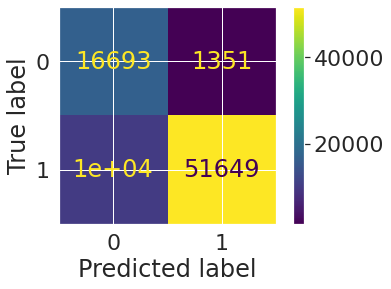

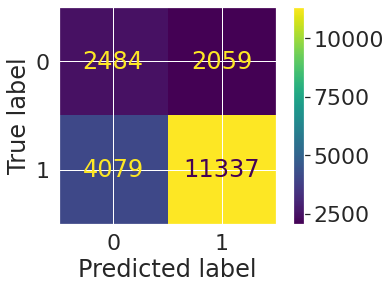

(array([0.37848545, 0.8462974 ]), array([0.54677526, 0.73540477]), array([0.44732577, 0.78696377]), array([ 4543, 15416]))


In [28]:
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support

final_pred = mlp_lightning.predict(test_x).detach()

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)*(y_true - y_pred))

print('Model performance on the test set:   MSE = %0.4f.' % mse(y_test, final_pred.numpy()))

cm = confusion_matrix(torch.Tensor(train_y), torch.round(mlp_lightning.predict(train_x).detach()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()
plt.savefig('images/mlp_confusion_matrix_train.pdf', bbox_inches='tight')
plt.show()

# The final model does out-perform the baseline model by about less than 1% and at the cost of significantly increased running time (it's about 7 times slower on my machine).
cm = confusion_matrix(torch.Tensor(y_test), torch.round(final_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()
plt.savefig('images/mlp_confusion_matrix_test.pdf', bbox_inches='tight')
plt.show()

print(precision_recall_fscore_support(torch.Tensor(y_test), torch.round(final_pred)))

In [29]:
# # # Feature Importances

# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'Feature': list(features.columns), 
                                'Importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('Importance', ascending = False).reset_index(drop=True)
feature_results['Rank'] = np.arange(1, len(feature_results)+1, 1)
feature_results_rank = feature_results.set_index('Rank')
feature_results_rank = feature_results_rank[['Feature', 'Importance']]
feature_results_rank.head(10)

,Feature,Importance
Rank,,
1,Credit Score,0.171302
2,Term_Long Term,0.071477
3,Current Loan Amount,0.045588
4,Purpose_small_business,0.036642
5,Purpose_Business Loan,0.034735
6,Home Ownership_Home Mortgage,0.027730
7,Purpose_Medical Bills,0.023369
8,Tax Liens,0.023175
9,Annual Income,0.022780


In [30]:
# # Use Feature Importances for Feature Selection

# Extract the names of the most important features
most_important_features = feature_results['Feature'][:10]

# Find the index that corresponds to each feature name
indices = [list(features.columns).index(x) for x in most_important_features]

# Keep only the most important features
X_train_reduced = X_train[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_train_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (79835, 10)
Most important testing  features shape:  (19959, 10)


In [31]:
# Create the model with the same hyperparamters
model_reduced = XGBClassifier(loss='ls', max_depth=5, max_features='auto',
                                  min_samples_leaf=6, min_samples_split=2, 
                                  n_estimators=500, random_state=42)

# Fit and test on the reduced set of features
model_reduced.fit(X_train_reduced, y_train)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('XGBoost Reduced Results: MSE = %0.4f' % mse(y_test, model_reduced_pred))

[15:54:57] WARNING: ../src/learner.cc:573: 
Parameters: { "loss", "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:54:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


XGBoost Reduced Results: MSE = 0.1851


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Model performance on the test set:   MSE = 0.1851.


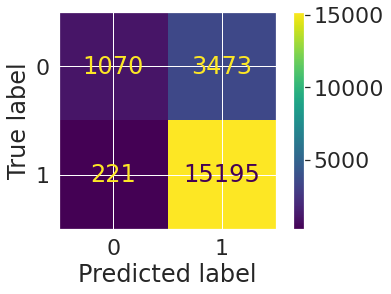

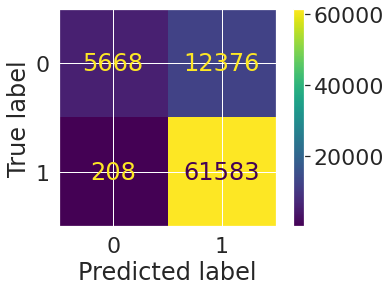

In [32]:
final_pred = model_reduced.predict(X_test_reduced)
print(final_pred[100:120])
# Function to calculate mean absolute error
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)*(y_true - y_pred))

print('Model performance on the test set:   MSE = %0.4f.' % mse(y_test, final_pred))

# The final model does out-perform the baseline model by about less than 1% and at the cost of significantly increased running time (it's about 7 times slower on my machine). 
plot_confusion_matrix(model_reduced, X_test_reduced, y_test)
plot_confusion_matrix(model_reduced, X_train_reduced, y_train)

In [33]:
# Mend the data for calculating and plotting Sharpley values
X_train = pd.DataFrame(X_train)
X_train.columns = features.columns
X_train.rename(columns = {'Years in current job_< 1 year':'Years in current job less than a year'}, inplace = True)
X_train.head()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Tax Liens,Term_Long Term,Term_Short Term,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job less than a year,Home Ownership_HaveMortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Purpose_Business Loan,Purpose_Buy House,Purpose_Buy a Car,Purpose_Debt Consolidation,Purpose_Educational Expenses,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Other,Purpose_major_purchase,Purpose_moving,Purpose_other,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding
0,-0.361023,-0.290981,0.528583,0.816073,-0.711771,1.372703,-0.351741,-0.264319,-0.050631,-0.115346,1.614134,-1.614134,-0.262214,-0.739784,-0.316354,-0.297815,3.912736,-0.267736,-0.247582,-0.244404,-0.219448,-0.203077,-0.298164,-0.045647,1.032248,-0.318601,-0.126325,-0.083136,-0.113535,0.521096,-0.029197,-0.248436,-0.106419,-0.182196,-0.059644,-0.038637,-0.253203,-0.00867,-0.051478,-0.032065,-0.034334
1,-0.355234,-0.261657,0.484072,0.163251,0.428567,-0.624846,-0.351741,0.113466,-0.025323,-0.115346,-0.619527,0.619527,-0.262214,1.351747,-0.316354,-0.297815,-0.255576,-0.267736,-0.247582,-0.244404,-0.219448,-0.203077,-0.298164,-0.045647,-0.968760,-0.318601,-0.126325,-0.083136,-0.113535,0.521096,-0.029197,-0.248436,-0.106419,-0.182196,-0.059644,-0.038637,-0.253203,-0.00867,-0.051478,-0.032065,-0.034334
2,-0.357882,-0.261657,-0.358240,-0.179778,-0.113094,0.373928,-0.351741,0.063415,-0.026209,-0.115346,1.614134,-1.614134,-0.262214,1.351747,-0.316354,-0.297815,-0.255576,-0.267736,-0.247582,-0.244404,-0.219448,-0.203077,-0.298164,-0.045647,1.032248,-0.318601,-0.126325,-0.083136,-0.113535,0.521096,-0.029197,-0.248436,-0.106419,-0.182196,-0.059644,-0.038637,-0.253203,-0.00867,-0.051478,-0.032065,-0.034334
3,2.781259,-0.251882,-0.316233,-0.487218,1.397854,0.973193,-0.351741,0.377486,0.096925,-0.115346,1.614134,-1.614134,-0.262214,1.351747,-0.316354,-0.297815,-0.255576,-0.267736,-0.247582,-0.244404,-0.219448,-0.203077,-0.298164,-0.045647,1.032248,-0.318601,-0.126325,-0.083136,-0.113535,0.521096,-0.029197,-0.248436,-0.106419,-0.182196,-0.059644,-0.038637,-0.253203,-0.00867,-0.051478,-0.032065,-0.034334
4,2.781259,-0.255642,-0.634944,0.090544,-0.127348,-0.225336,-0.351741,-0.193216,-0.037176,-0.115346,-0.619527,0.619527,3.813686,-0.739784,-0.316354,-0.297815,-0.255576,-0.267736,-0.247582,-0.244404,-0.219448,-0.203077,-0.298164,-0.045647,-0.968760,-0.318601,-0.126325,-0.083136,-0.113535,0.521096,-0.029197,-0.248436,-0.106419,-0.182196,-0.059644,-0.038637,-0.253203,-0.00867,-0.051478,-0.032065,-0.034334


In [34]:
idx = 14

In [75]:
# Load JS visualization code to notebook
shap.initjs()

# Explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, 
                shap_values[idx,:], 
                X_train.iloc[idx,:], show=False)
# plt.savefig('images/forceplot_kaggle.pdf', bbox_inches='tight')

In [76]:
import matplotlib.pyplot as plt

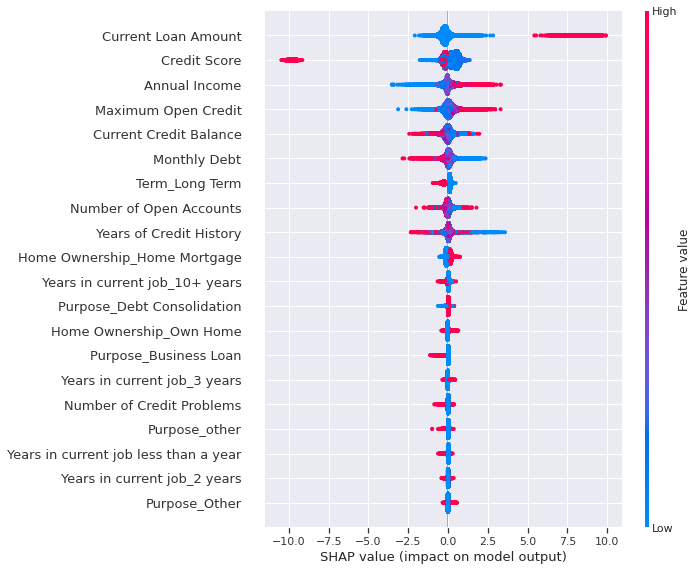

In [77]:
# Summarize the effects of all the features
shap.summary_plot(shap_values, X_train, show=False)
plt.savefig('images/summary_plot_kaggle.pdf', bbox_inches='tight')

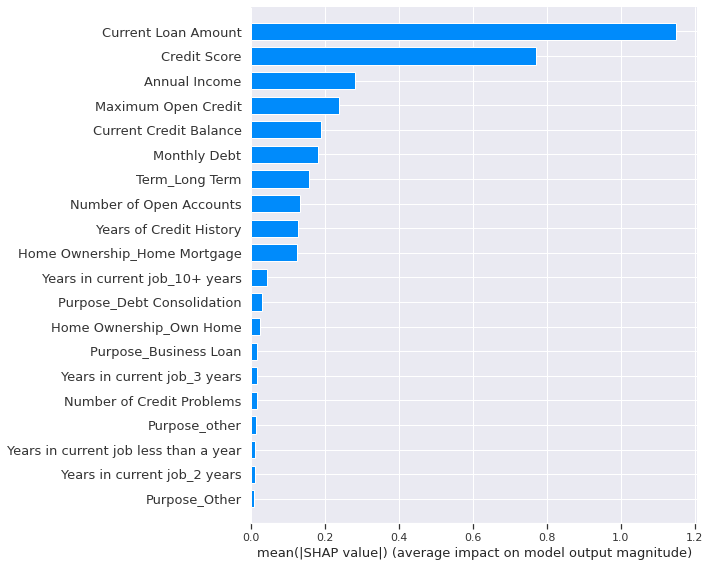

In [78]:
# Summarize the effects of all the features
shap.summary_plot(shap_values, X_train, plot_type='bar', show=False)
plt.savefig('images/summary_plot_bar_kaggle.pdf', bbox_inches='tight')

## Using LIME as XAI criterion
https://github.com/marcotcr/lime

In [52]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['bad', 'good'],
    mode='classification'
)

# Use test data for plotting
X = pd.DataFrame(X_train)
X.columns = features.columns
X.rename(columns = {'Years in current job_< 1 year':'Years in current job less than a year'}, inplace = True)
X.head()

exp = explainer.explain_instance(
    data_row=X.iloc[1], 
    predict_fn=model.predict_proba
)

In [53]:
exp.show_in_notebook(show_table=True)
exp.save_to_file('images/lime.html')

In [ ]:
import pdfkit
pdfkit.from_file('images/lime.html', 'images/lime.pdf')